In [93]:
# code to replicate arXiv:1412.2043v2
import numpy as np
from mpmath import mp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root, root_scalar
from collections import namedtuple
from tqdm.notebook import tqdm
import h5py
import util
# all units should be natural units and in GeV unless otherwise noted

## General Constants and Functions

In [2]:
# constants
M_pl = 2.435e18 # reduced Planck mass [GeV] from wikipedia (https://en.wikipedia.org/wiki/Planck_mass)
m_pl = 1.220910e19 # Planck mass [GeV] from wikipedia (https://en.wikipedia.org/wiki/Planck_mass)
g_star = 427/4 # during reheating from paper
sigma_eff = 1e-31 # [GeV^-2] from paper heavy neutrino exchange 
N_f = 3 # [1] fermion generations
# TODO: renormalization group running?
g_2 = 0.652 # [1] from wikipedia (https://en.wikipedia.org/wiki/Mathematical_formulation_of_the_Standard_Model#Free_parameters)
alpha = g_2**2 / (4 * np.pi) # eq. from paper
c_shaleron = 28/79 # from paper
g_star_0 = 43/11 # from paper
eta_B_observed = 6e-10 # from paper
L_to_B_final_factor = c_shaleron * g_star_0 / g_star # formula from paper (*)

In [3]:
# helper functions
def eta_L_a_to_eta_B_0(eta_L_a): 
    return L_to_B_final_factor * eta_L_a # formula from paper (*)

def calc_Gamma_a(m_a, f_a):
    m_a = mp.mpf(m_a)
    f_a = mp.mpf(f_a)
    return float(alpha**2 / (64 * np.pi**3) * m_a**3 / f_a**2) # from paper

def calc_temperature(rho_R):
    # in the paper its
    # (np.pi**2 / 3 * g_star * rho_R)**(1/4)
    return (rho_R / g_star * 30 / np.pi**2)**(1/4)

def calc_radiation_energy_density(T):
    return np.pi**2 / 30 * g_star * T**4

def calc_hubble_parameter(rho_total):
    return np.sqrt(rho_total) / (np.sqrt(3) * M_pl) # Friedmann

def calc_rho_R(rho_phi, rho_tot):
    return rho_tot - rho_phi # neglegt axion 

def calc_energy_density_from_hubble(H):
    return 3 * M_pl**2 * H**2 # Friedmann eq.

def calc_lepton_asym_in_eqi(T, mu_eff):
    return 4 / np.pi**2 * mu_eff * T**2 # boltzmann thermodynamics

zeta3 = 1.20206
g_photon = 2
def calc_photon_number_density(T):
    return zeta3 / np.pi**2 * g_photon * T**3 # K&T (3.52)

def calc_asym_parameter(T, n_L):
    n_gamma = calc_photon_number_density(T)
    return n_L / n_gamma # definition

def n_L_to_eta_B_final(T, n_L):
    return -eta_L_a_to_eta_B_0(calc_asym_parameter(T, n_L)) # -sign from defintion of (anti)matter

def calc_Gamma_L(T):
    n_l_eq = 2 / np.pi**2 * T**3
    return 4 * n_l_eq * sigma_eff # is this term only active in a certain range?

In [4]:
# analyical results for reheating
def calc_rho_phi_analytical(t0, t, R_osc, R, rho_phi_0, Gamma_phi):
    return rho_phi_0 * (R / R_osc)**-3 * np.exp(- Gamma_phi * (t - t0)) # K&T (8.30)

def calc_rho_R_analytical(rho_R, t0, t, R_osc, R, rho_phi_0, Gamma_phi):
    start = (6 / np.pi)**0.5 / 10 * m_pl * Gamma_phi * rho_phi_0**0.5 * (R / R_osc)**(-3/2) * (1 - (R / R_osc)**(-5/2)) # K&T (8.32)
    t_RH = 1 / Gamma_phi
    rad_dom = rho_R[-1] * (R / R[-1])**(-4)
    return np.where(t < t_RH, start, rad_dom)

In [5]:
def calc_H_inf_max(f_a):
    return 6e11 * (f_a / 1e15) # paper

def constraints(m_a, f_a, Gamma_phi, H_inf):
    # all from paper:
    assert Gamma_phi <= H_inf # no inflaton decay before the end of inflation
    assert H_inf <= calc_H_inf_max(f_a) # isocurvature
    assert m_a <= H_inf # axion not part of inflation
    assert m_a >= 8e4*(f_a / 1e15)**(2/3) # reheating from axion decay large enough  

In [6]:
def calc_end_time(m_a, Gamma_phi, num_osc, larger_than_reheating_by):
    t_osc = 1/(2*m_a) if Gamma_phi >= m_a else 2/(3*m_a)
    axion_period = 2*np.pi/m_a
    t_axion = t_osc + axion_period * num_osc
    t_reheating = 1 / Gamma_phi * larger_than_reheating_by
    return max((t_axion, t_reheating))

def calc_start_time(H_inf):
    return 1 / H_inf

## Analytical Solution

In [97]:
def calc_Delta_a(m_a, f_a, Gamma_phi, theta0):
    a0 = theta0 * f_a
    Delta_a_prime = 2*np.pi**2 / alpha * f_a * a0**2 / (m_a * M_pl**2) * min((1, (Gamma_phi / m_a)**0.5))
    Delta_a = max((1, Delta_a_prime))
    return Delta_a

def compute_B_asymmetry_analytic(m_a, f_a, Gamma_phi, theta0=1):
    Delta_phi_prime = (m_a / Gamma_phi)**(5 / 4)
    Delta_phi = max((1, Delta_phi_prime))
    Delta_a = calc_Delta_a(m_a, f_a, Gamma_phi, theta0)
    a0 = f_a * theta0
    eta_L_max = sigma_eff * a0 / (g_star**0.5 * f_a) * m_a * M_pl * min((1, (Gamma_phi / m_a)**0.5))
    T_RH = 2e13*(Gamma_phi / 1e9)**0.5
    T_L = g_star**0.5 / (np.pi * M_pl * sigma_eff)
    kappa = np.where(m_a > Gamma_phi, T_RH / T_L, 0)
    C = np.where(m_a > Gamma_phi, 2.2, 1.5) # factor determined in paper
    eta_L_a = C * Delta_a**-1 * Delta_phi**-1 * eta_L_max * np.exp(-kappa)
    return eta_L_a_to_eta_B_0(eta_L_a)

In [98]:
def print_table():
    theta0 = 1
    f_a_list = [1e12, 1e12, 1e15, 1e15]
    m_a_list = [3e7, 3e6, 1e10, 1e9]
    Gamma_phi_list = [3e6, 3e7, 1e9, 1e10]
    print("f_a, m_a, Gamma_phi, eta_L^a, Delta_a")
    for f_a, m_a, Gamma_phi in zip(f_a_list, m_a_list, Gamma_phi_list):
        print(f"{f_a:e}, {m_a:e}, {Gamma_phi:e}, {compute_B_asymmetry_analytic(m_a, f_a, Gamma_phi):e}, {calc_Delta_a(m_a, f_a, Gamma_phi, theta0):e}")
print_table() # 

f_a, m_a, Gamma_phi, eta_L^a, Delta_a
1.000000e+12, 3.000000e+07, 3.000000e+06, 3.310348e-10, 1.000000e+00
1.000000e+12, 3.000000e+06, 3.000000e+07, 1.376469e-09, 1.000000e+00
1.000000e+15, 1.000000e+10, 1.000000e+09, 8.746394e-09, 3.112049e+00
1.000000e+15, 1.000000e+09, 1.000000e+10, 4.662283e-09, 9.841164e+01


## Numerical Simulation 

In [9]:
SimulationResult = namedtuple("SimulationResult", 
    ["t", "rho_phi", "rho_R", "rho_tot", "T", "H", "R", "theta", "theta_dot", "n_L"])

In [10]:
# numerical implementation of the complete model
theta_index = 3
theta_diff_index = theta_index + 1
n_L_index = theta_diff_index + 1
R_osc = 1.0

def rhs(log_t, y, Gamma_phi, m_a):
    # coordinate transformation
    t = np.exp(log_t)
    rho_phi, rho_tot, R = np.exp(y[:theta_index])
    theta = y[theta_index]
    d_theta_d_log_t = y[theta_diff_index]
    theta_dot = d_theta_d_log_t / t
    rho_R = calc_rho_R(rho_phi, rho_tot)
    T = calc_temperature(rho_R)
    n_L = y[n_L_index]
    
    # Friedmann
    H = calc_hubble_parameter(rho_tot)
    d_log_R_d_log_t = t * H
    
    # reheating energy equations rewritten in rho_phi and roh_tot instead of rho_phi and phi_R and in loglog space
    d_log_rho_phi_d_log_t = - t * (3 * H + Gamma_phi)
    d_log_rho_tot_d_log_t = - H * t * (4 - rho_phi / rho_tot)
    
    # axion eom (Klein Gordon) in theta and log t
    theta_dot2         = - 3 * H * theta_dot - m_a**2 * theta
    d2_theta_d_log_t_2 = d_theta_d_log_t + t**2 * theta_dot2
    
    # Boltzmann eq. for lepton asymmetry
    mu_eff = theta_dot
    n_L_eq = calc_lepton_asym_in_eqi(T, mu_eff)
    Gamma_L = calc_Gamma_L(T)
    d_n_L_d_log_t = t * (- 3 * H * n_L - Gamma_L * (n_L - n_L_eq))
    
    # final result
    return (
        d_log_rho_phi_d_log_t, d_log_rho_tot_d_log_t, 
        d_log_R_d_log_t, 
        d_theta_d_log_t, d2_theta_d_log_t_2,
        d_n_L_d_log_t,
    )

def simulate(m_a, f_a, Gamma_phi, H_inf, theta0=1.0, 
             start=None, end=None, num_osc=30, larger_than_reheating_by=5, samples=500):
    if start is None: start = calc_start_time(H_inf)
    if end is None: end = calc_end_time(m_a, Gamma_phi, num_osc, larger_than_reheating_by)
    constraints(m_a, f_a, Gamma_phi, H_inf) # make sure constrains are satisfied 
    rho_phi_0 = calc_energy_density_from_hubble(H_inf)
    initial_conditions = np.array([np.log(rho_phi_0), np.log(rho_phi_0), np.log(R_osc), theta0, 0.0, 0.0])
    interval = (start, end) 
    sol = solve_ivp(rhs, np.log(interval), initial_conditions, 
                    args=(Gamma_phi, m_a), 
                    t_eval=np.log(np.geomspace(*interval, samples))[:-1], method="RK45")
    t = np.exp(sol.t)
    rho_phi, rho_tot, R = np.exp(sol.y[:theta_index])
    theta, n_L = sol.y[theta_index], sol.y[n_L_index]
    theta_dot = sol.y[theta_diff_index] / t
    rho_R = calc_rho_R(rho_phi, rho_tot)
    T = calc_temperature(rho_R)
    H = calc_hubble_parameter(rho_tot)
    return SimulationResult(t=t, rho_R=rho_R, rho_phi=rho_phi, rho_tot=rho_tot, H=H, R=R, T=T, theta=theta, theta_dot=theta_dot, n_L=n_L)

In [11]:
def count_oscillations(theta):
    s = np.sign(theta) 
    roots = np.sum(s[:-1] != s[1:])
    return roots // 2

def find_local_maxima(theta):
    return np.where((theta[1:-1] > theta[:-2]) & (theta[1:-1] > theta[2:]))[0]

In [12]:
def make_time_plots(m_a, f_a, Gamma_phi, H_inf, show_all=True, save=False, add_title=True, **kwargs):
    t, rho_phi, rho_R, rho_tot, T, H, R, theta, theta_dot, n_L = simulate(m_a, f_a, Gamma_phi, H_inf, **kwargs)
      
    rho_phi_0 = calc_energy_density_from_hubble(H_inf)
    time_label = r"Time, $t \cdot \mathrm{GeV}$"
    T_RH = 2e13 * np.sqrt(Gamma_phi / 1e9) # paper
    T_max = 5e13 * (Gamma_phi / 1e9)**(1/4) * (H_inf / 1e11)**(1/2) # paper
    T_RH_KT = 0.55 * g_star**(-1/4) * (m_pl * Gamma_phi)**0.5 # K&T
    T_max_KT = 0.8 * g_star**(-1/4) * rho_phi_0**(1/8) * (Gamma_phi * m_pl)**(1/4) # K&T
    t_RH = 1 / Gamma_phi
    rho_R_max_Weinberg = 0.139 * Gamma_phi / H_inf * rho_phi_0
    T_max_Weinberg = calc_temperature(rho_R_max_Weinberg)
    t_osc = t[np.where(m_a > H)[0][0]]
    
    if show_all:        
        # energy densities
        plt.figure()
        plt.loglog(t, rho_phi, color="tab:blue",   label=r"Numerical: $\rho_\phi$")
        plt.loglog(t, rho_R,   color="tab:orange", label=r"Numerical: $\rho_R$")
        #plt.loglog(t, rho_tot, label=r"Numerical: $\rho_\mathrm{tot}$")
        plt.loglog(t, calc_rho_phi_analytical(calc_start_time(H_inf), t, R_osc, R, rho_phi_0, Gamma_phi), 
                   ls="--", color="tab:blue", label=r"Analytical: $\rho_\phi$")
        plt.loglog(t, calc_rho_R_analytical(rho_R, calc_start_time(H_inf), t, R_osc, R, rho_phi_0, Gamma_phi), 
                   ls="--", color="tab:orange", label=r"Analytical: $\rho_R$")
        plt.axvline(t_RH, label=r"Reheating time, $t_\mathrm{RH}$", color="black", ls="--")
        #plt.axhline(rho_R_max_Weinberg, color="green", ls="-", label="Weinberg max rho_R")
        #plt.axhline(calc_radiation_energy_density(T_RH_KT), color="green", ls="--", label="K&T max rho")
        plt.legend()
        plt.xlabel(time_label)
        plt.ylabel(r"Energy Density, $\rho / \mathrm{GeV}^4$")
        plt.show()

        # temperature
        plt.figure()
        plt.loglog(t, T, label="Temperature", color="tab:blue") # from simulation
        # analytic results for different epochs
        i_RH = np.where(t_RH <= t)[0][0]
        max_T_idx = np.argmax(T)
        plt.loglog(t[:i_RH], T[max_T_idx]*(R[:i_RH] / R[max_T_idx])**(-3/8), color="tab:blue", ls="--", label="Reheating")
        plt.loglog(t[i_RH:], T[-1] * (R[i_RH:]/R[-1])**-1, color="tab:blue", ls=":", label="Radiation Domination")
        # reheating and maximal temperature
        plt.axvline(t_RH, label="Reheating Time", ls="--", color="black")
        #plt.axhline(T_RH, label="Reheating (paper)", ls=":", color="grey") # ~ same as K&T
        plt.axhline(T_RH_KT, label="Reheating T (K&T)", ls="--", color="black")
        #plt.axhline(T_max, label="Max. T (paper)", ls=":", color="red")
        plt.axhline(T_max_KT, label="Max. T (K&T)", ls="--", color="red")
        #plt.axhline(T_max_Weinberg, label="Max. T (Weinberg)", ls="-.", color="red")
        # labels
        plt.legend() # ncol=2)
        plt.xlabel(time_label)
        plt.ylabel(r"Temperature, $T / \mathrm{GeV}$")
        #plt.ylim(plt.ylim()[0], np.max(T) * 2)
        plt.show()

        # scale factor
        plt.figure()
        plt.subplot(1,2,1)
        plt.loglog(t, R / R_osc)
        plt.xlabel(time_label)
        plt.ylabel(r"Scale Parameter, $R / R_\mathrm{osc}$")
        # Hubble parameter
        plt.subplot(1,2,2)
        plt.loglog(t, H, label="Numerical")
        plt.loglog(t, 1 / (2*t), label="Radiation $H = 1/2t$")
        plt.xlabel(time_label)
        plt.ylabel(r"Hubble parameter, $H / \mathrm{GeV}$")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # axion field 
        plt.figure()
        plt.semilogx(t, theta, label=r"Axion field $a(t) / f_a = \theta(t)$")
        plt.xlabel(time_label)
        plt.ylabel(r"Axion angle, $\theta = a(t) / f_a$")
        plt.axvline(t_osc, label=r"Oscillation Onset: $H_\mathrm{osc} = m_a$", color="black", ls="--")
        plt.axhline(0, label=r"$\theta = 0$", color="black", ls=":")
        plt.legend()
        plt.show()

    # asymmetry parameter
    plt.figure()
    # the minus sign comes from the fact that we are actually computing B - L
    eta_B = n_L_to_eta_B_final(T[1:], n_L[1:])
    plt.loglog(t[1:], eta_B, label="Boltzmann")
    plt.axhline(eta_B[-1], color="black", ls=":", label="Final Value")
    plt.axvline(t_osc, color="black", ls="--", label="Oscillation Onset")
    plt.xlabel(time_label)
    plt.ylabel(r"Projected Baryon Asymmetry, $\eta_B$")
    plt.legend(loc="lower right")
    if add_title:
        plt.title(f"$m_a =$ {m_a:.1e} GeV, $\\Gamma_\\phi =$ {Gamma_phi:.1e} GeV,\n$f_a =$ {f_a:.1e} GeV, $H_\\mathrm{{inf}} =$ {H_inf:.1e} GeV")
    plt.tight_layout()
    if save:
        plt.savefig(util.make_plot_path(f"lepto_axion_osc_m_a={m_a:.1e}Gamma_phi={Gamma_phi:.1e}f_a={f_a:.1e}H_inf={H_inf:.1e}_plot.pdf"))
    plt.show()
    
    print("axion oscillations:", count_oscillations(theta))
    print("final asymmetry:", eta_B[-1])

In [13]:
f_a = 3e14
H_inf = 2e10

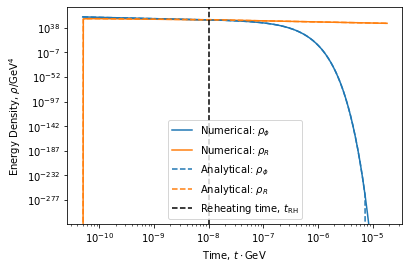

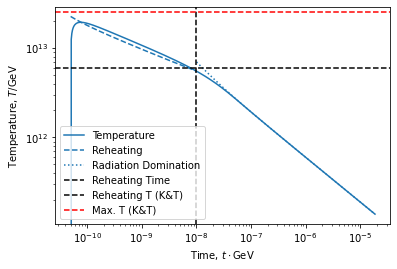

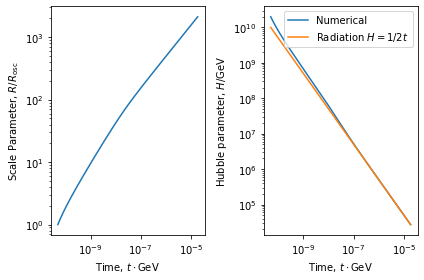

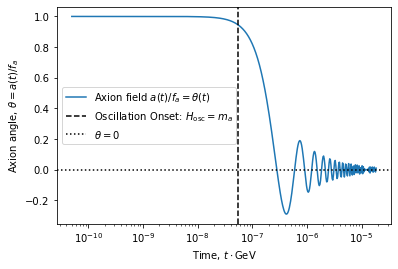

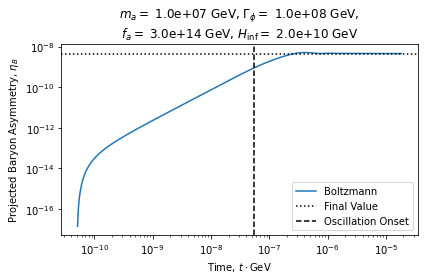

axion oscillations: 25
final asymmetry: 4.5866256694344536e-09


In [14]:
make_time_plots(1e7, f_a, 1e8, H_inf, save=False, show_all=True)

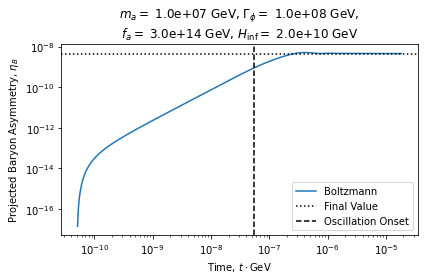

axion oscillations: 25
final asymmetry: 4.5866256694344536e-09


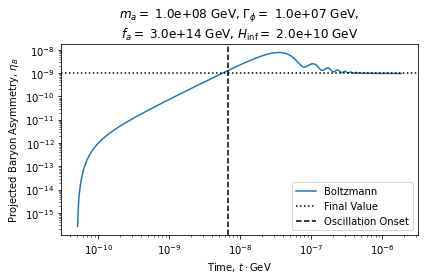

axion oscillations: 27
final asymmetry: 9.695220593794248e-10


In [15]:
for m_a, Gamma_phi in [(1e7, 1e8), (1e8, 1e7)]:
    make_time_plots(m_a, f_a, Gamma_phi, H_inf, save=True, show_all=False)

## Axion Decay and Entropy Production

In [16]:
def rhs_axion_decay(log_t, y, Gamma_a):
    rho_R, rho_a, R = np.exp(y)
    t = np.exp(log_t)
    H = calc_hubble_parameter(rho_a + rho_R)
    d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
    d_log_rho_a_d_log_t = - t * (3 * H + Gamma_a)
    d_log_R_d_log_t = t * H
    return d_log_rho_R_d_log_t, d_log_rho_a_d_log_t, d_log_R_d_log_t

R_0 = 1.0

AxionDecayResult = namedtuple("AxionDecayResult", ["t", "rho_R", "rho_a", "R", "T", "n_L"])

def axion_energy_density(theta, theta_dot, m_a, f_a):
    rho_pot = 0.5 * m_a**2 * f_a**2 * theta**2
    rho_kin = 0.5 * f_a**2 * theta_dot**2
    return rho_kin + rho_pot

def simulate_axion_decay(m_a, f_a, bg_sol, end=None, steps=500):
    Gamma_a = calc_Gamma_a(m_a, f_a)

    start = np.log(bg_sol.t[-1])
    t_axion_decay = 1 / Gamma_a
    end = end if end is not None else np.log(t_axion_decay * 1e3)
    interval = (start, end)

    # at the maximum the axion only has potential energy
    rho_a_initial = axion_energy_density(bg_sol.theta[-1], bg_sol.theta_dot[-1], m_a, f_a)

    rho_R_initial = bg_sol.rho_R[-1]
    initial_conditions = (np.log(rho_R_initial), np.log(rho_a_initial), np.log(R_0))

    axion_decay_sol = solve_ivp(rhs_axion_decay, interval, initial_conditions, 
                                args=(Gamma_a,), t_eval=np.linspace(*interval, steps))
    t = np.exp(axion_decay_sol.t)
    rho_R, rho_a, R = np.exp(axion_decay_sol.y)
    n_L_start = bg_sol.n_L[-1]
    n_L = n_L_start * (R_0 / R)**3
    T = calc_temperature(rho_R)
    
    return AxionDecayResult(t=t, rho_R=rho_R, rho_a=rho_a, R=R, T=T, n_L=n_L)

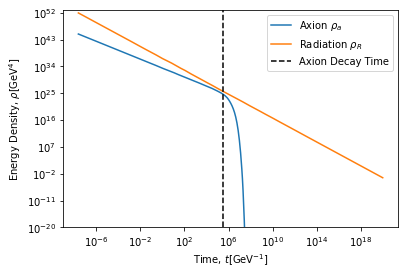

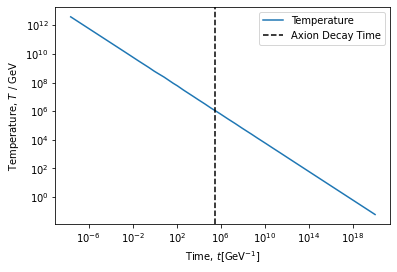

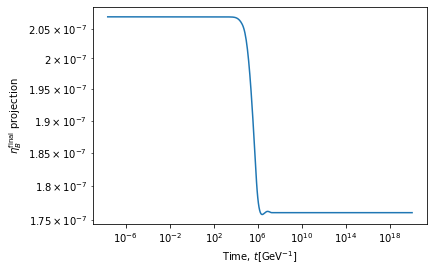

In [33]:
Gamma_phi = 8e9
m_a = 8e9

bg_sol = simulate(m_a, f_a, Gamma_phi, H_inf)
t, rho_R, rho_a, R, T, n_L = simulate_axion_decay(m_a, f_a, bg_sol, end=np.log(1e20))
eta_B_final_proj = n_L_to_eta_B_final(T, n_L)
t_axion_decay = 1 / calc_Gamma_a(m_a, f_a)

plt.figure()
plt.loglog(t, rho_a, label=r"Axion $\rho_a$")
plt.loglog(t, rho_R, label=r"Radiation $\rho_R$")
plt.axvline(t_axion_decay, color="black", ls="--", label="Axion Decay Time")
plt.ylim(1e-20, rho_R[0]*10)
time_label = r"Time, $t [\mathrm{GeV}^{-1}]$"
plt.xlabel(time_label)
plt.ylabel(r"Energy Density, $\rho [\mathrm{GeV}^4]$")
plt.legend()
plt.show()

plt.figure()
T = calc_temperature(rho_R)
plt.loglog(t, T, label="Temperature")
plt.axvline(t_axion_decay, color="black", ls="--", label="Axion Decay Time")
plt.xlabel(time_label)
plt.ylabel(r"Temperature, $T$ / GeV")
plt.legend()
plt.show()
    
plt.figure()
plt.loglog(t, eta_B_final_proj)
plt.xlabel(time_label)
plt.ylabel(r"$\eta_B^\mathrm{final}$ projection")
plt.show()

In [ ]:
def store_data(filename, axis_arrays, result_array):
    filepath = util.make_output_data_path(filename)
    hdf5_file = h5py.File(filepath, "w")
    
    
def load_data(filename):
    pass

## Final $\eta_B$ numerical

In [18]:
def compute_B_asymmetry(m_a, f_a, Gamma_phi, H_inf, theta0=1.0):
    bg_res = simulate(m_a, f_a, Gamma_phi, H_inf, theta0=theta0)
    axion_decay_res = simulate_axion_decay(m_a, f_a, bg_res)
    return n_L_to_eta_B_final(axion_decay_res.T[-1], axion_decay_res.n_L[-1])

## Contour Plot

In [19]:
def sample_parameter_space(func, f_a, H_inf, min_Gamma_phi=1e6, max_Gamma_phi=1e10, min_m_a=2e5, max_m_a=1e10,
                         num_m_a_samples=30, num_Gamma_phi_samples=31):
    Gamma_phi_s = np.geomspace(min_Gamma_phi, max_Gamma_phi, num_Gamma_phi_samples)
    m_a_s = np.geomspace(min_m_a, max_m_a, num_m_a_samples)
    eta_B_s = np.array([[func(m_a, f_a, Gamma_phi, H_inf) for m_a in m_a_s] for Gamma_phi in tqdm(Gamma_phi_s)])
    return m_a_s, Gamma_phi_s, eta_B_s

In [100]:
f_a = 3e14
H_inf = 2e10
m_a_s, Gamma_phi_s, eta_B_numerical = sample_parameter_space(compute_B_asymmetry, f_a, H_inf)
_, _, eta_B_analytical = sample_parameter_space(lambda *args: compute_B_asymmetry_analytic(*args[:-1]), f_a, H_inf)

<ipython-input-16-031592c6d528>:5: RuntimeWarning: divide by zero encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
/home/jana/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)
<ipython-input-16-031592c6d528>:2: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-16-031592c6d528>:5: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-16-031592c6d528>:5: RuntimeWarning: overflow encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


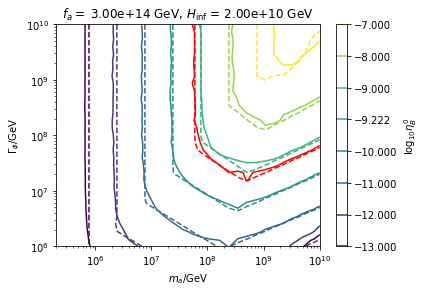

In [103]:
levels = np.sort(np.concatenate([np.arange(-13, -7 + 1), [np.log10(eta_B_observed)]]))

# analytic result from paper
CS = plt.contour(m_a_s, Gamma_phi_s, np.log10(eta_B_analytical), levels=levels, linestyles="dashed")
plt.colorbar().set_label(r"$\log_{10} \eta_B^0$")
CS.collections[np.where(CS.levels == np.log10(eta_B_observed))[0][0]].set_color("red")

# numerical result
CS2 = plt.contour(m_a_s, Gamma_phi_s, np.log10(eta_B_numerical), levels=levels)
CS2.collections[np.where(CS2.levels == np.log10(eta_B_observed))[0][0]].set_color("red")

# labels
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$m_a / \mathrm{GeV}$")
plt.ylabel(r"$\Gamma_\phi / \mathrm{GeV}$")
plt.tight_layout()
plt.title(f"$f_a =$ {f_a:.2e} GeV, $H_\\mathrm{{inf}}$ = {H_inf:.2e} GeV")
plt.savefig(util.make_plot_path("sbg_leptogenesis_axion_osc_contour_plot.pdf"))

## Search for the Observed Asymmetry and Compute Possible Parameter Volume

In [147]:
def search_bracket(f, hint, max_trys=10, eps=1):
    delta = eps
    for i in range(max_trys):
        delta += eps
        interval = l, r = hint - delta, hint + delta
        if np.sign(f(l)) != np.sign(f(r)):
            return interval
    raise RuntimeError("interval not found")
    
def order(xs, ys):
    i = np.argmax(ys)
    x, y = xs[i], ys[i]
    xs = list(xs); ys = list(ys)
    xs.remove(x); ys.remove(y)
    ordered_x = [x]; ordered_y = [y]
    while xs:
        i = min(range(len(xs)), key=lambda i: (xs[i] - x)**2 + (ys[i] - y)**2)
        ordered_x.append(xs[i]); ordered_y.append(ys[i])
        del xs[i]; del ys[i]
    return ordered_x, ordered_y

In [162]:
def compute_correct_curve(m_a_s, Gamma_phi_s, f_a, H_inf, use_tqdm=False):
    correct_Gamma_phis = []
    correct_m_as = []
    for Gamma_phi in (tqdm(Gamma_phi_s) if use_tqdm else Gamma_phi_s):
        goal_m_a_analyical = lambda log_m_a: np.log(compute_B_asymmetry_analytic(np.exp(log_m_a), f_a, Gamma_phi)) - np.log(eta_B_observed)
        goal_m_a_numerical = lambda log_m_a: np.log(compute_B_asymmetry(np.exp(log_m_a), f_a, Gamma_phi, H_inf)) - np.log(eta_B_observed)
        try:
            ans = root_scalar(goal_m_a_analyical, bracket=(np.log(m_a_s[0]), np.log(m_a_s[-1])))
            if ans.converged:
                bracket = search_bracket(goal_m_a_numerical, ans.root)
                ans = root_scalar(goal_m_a_numerical, bracket=bracket)
                if ans.converged:
                    correct_Gamma_phis.append(Gamma_phi)
                    correct_m_as.append(np.exp(ans.root))
        except ValueError:
            pass

    for m_a in (tqdm(m_a_s) if use_tqdm else m_a_sa):
        goal_Gamma_phi_analyical = lambda log_Gamma_phi: np.log(compute_B_asymmetry_analytic(m_a, f_a, np.exp(log_Gamma_phi))) - np.log(eta_B_observed)
        goal_Gamma_phi_numerical = lambda log_Gamma_phi: np.log(compute_B_asymmetry(m_a, f_a, np.exp(log_Gamma_phi), H_inf)) - np.log(eta_B_observed)
        try:
            ans = root_scalar(goal_Gamma_phi_analyical, bracket=(np.log(Gamma_phi_s[0]), np.log(Gamma_phi_s[-1])))
            if ans.converged:
                bracket = search_bracket(goal_Gamma_phi_numerical, ans.root)
                ans = root_scalar(goal_Gamma_phi_numerical, bracket=bracket)
                if ans.converged:
                    correct_Gamma_phis.append(np.exp(ans.root))
                    correct_m_as.append(m_a)
        except ValueError:
            pass
    return order(correct_m_as, correct_Gamma_phis)

In [ ]:
f_a_s = np.geomspace(4e10, 4e15, 5)
correct_curves = [compute_correct_curve(m_a_s, Gamma_phi_s, f_a, H_inf, 1.0) for f_a in tqdm(f_a_s)]

Text(0, 0.5, '$\\Gamma_\\phi$ / GeV')

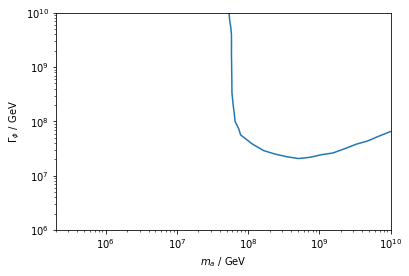

In [161]:
cmap = plt.get_cmap("inferno")
for f_a, correct_curve in zip(f_a, correct_curve):
    plt.loglog(correct_m_as, correct_Gamma_phis)
plt.xlim(np.min(m_a_s), np.max(m_a_s))
plt.ylim(np.min(Gamma_phi_s), np.max(Gamma_phi_s))
plt.xlabel("$m_a$ / GeV")
plt.ylabel("$\\Gamma_\\phi$ / GeV")
plt